# Mushroom Classification

## Project Topic

The goal of this project is to build an accurate model for predicting if a mushroom is edible based on catigorical information about features of the mushroom. 

This is a binary classification problem where a mushroom can be classified as either edible or poisonous. I will work up to a sophisticated model by exploring the performance of models utilizing logistic regression, decision trees with ensemble methods, and support vector machines.

My motivation behind this project is to explore the benifits and drawbacks of different classification approaches on a straightforward binary classification problem and to learn intuition about an optimal approach on similar problems in the future.

## Data

This project uses the "Mushroom" dataset from the UCI Machine learning repository:

Mushroom [Dataset]. (1981). UCI Machine Learning Repository. https://doi.org/10.24432/C5959T.

To obtain the dataset I am importing it using UCI's python library [ucimlrepo](https://github.com/uci-ml-repo/ucimlrepo).

This dataset is licensed under CC BY 4.0 and is available for adaptation for any purpose as long as appropriate credit is given.

In [43]:
from ucimlrepo import fetch_ucirepo

mushroom = fetch_ucirepo(id=73)

# Save data locally for availability
mushroom.data.features.to_csv('data/features.csv')
mushroom.data.targets.to_csv('data/targets.csv')

## Data Description

The raw data contains two tabulated datasets. One called 'targets' and the other 'features'.

### Targets

- Columns: 1
- Rows: 8124
- Size: 63.6 KB
- one feature "poisonous": categorical value with edible=e, poisonous=p

In [44]:
mushroom.data.targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   poisonous  8124 non-null   object
dtypes: object(1)
memory usage: 63.6+ KB


### Features

- Columns: 22
- Rows: 8124
- Size: 1.4 MB

In [45]:
mushroom.data.features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

In [46]:
# UCI provides a description of each feature, they are all categorical except "bruises" which is binary
print(mushroom.metadata.additional_info.variable_info)

     1. cap-shape:                bell=b,conical=c,convex=x,flat=f, knobbed=k,sunken=s
     2. cap-surface:              fibrous=f,grooves=g,scaly=y,smooth=s
     3. cap-color:                brown=n,buff=b,cinnamon=c,gray=g,green=r, pink=p,purple=u,red=e,white=w,yellow=y
     4. bruises?:                 bruises=t,no=f
     5. odor:                     almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
     6. gill-attachment:          attached=a,descending=d,free=f,notched=n
     7. gill-spacing:             close=c,crowded=w,distant=d
     8. gill-size:                broad=b,narrow=n
     9. gill-color:               black=k,brown=n,buff=b,chocolate=h,gray=g, green=r,orange=o,pink=p,purple=u,red=e, white=w,yellow=y
    10. stalk-shape:              enlarging=e,tapering=t
    11. stalk-root:               bulbous=b,club=c,cup=u,equal=e, rhizomorphs=z,rooted=r,missing=?
    12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
    13. stalk-surfac

## Data Cleaning

This data is in decent shape already, but there are some cleaning tasks to do. I will check for missing values in the data. I'm using a visualization here to quickly get an impression of the scale of missing data and how it could effect our results.

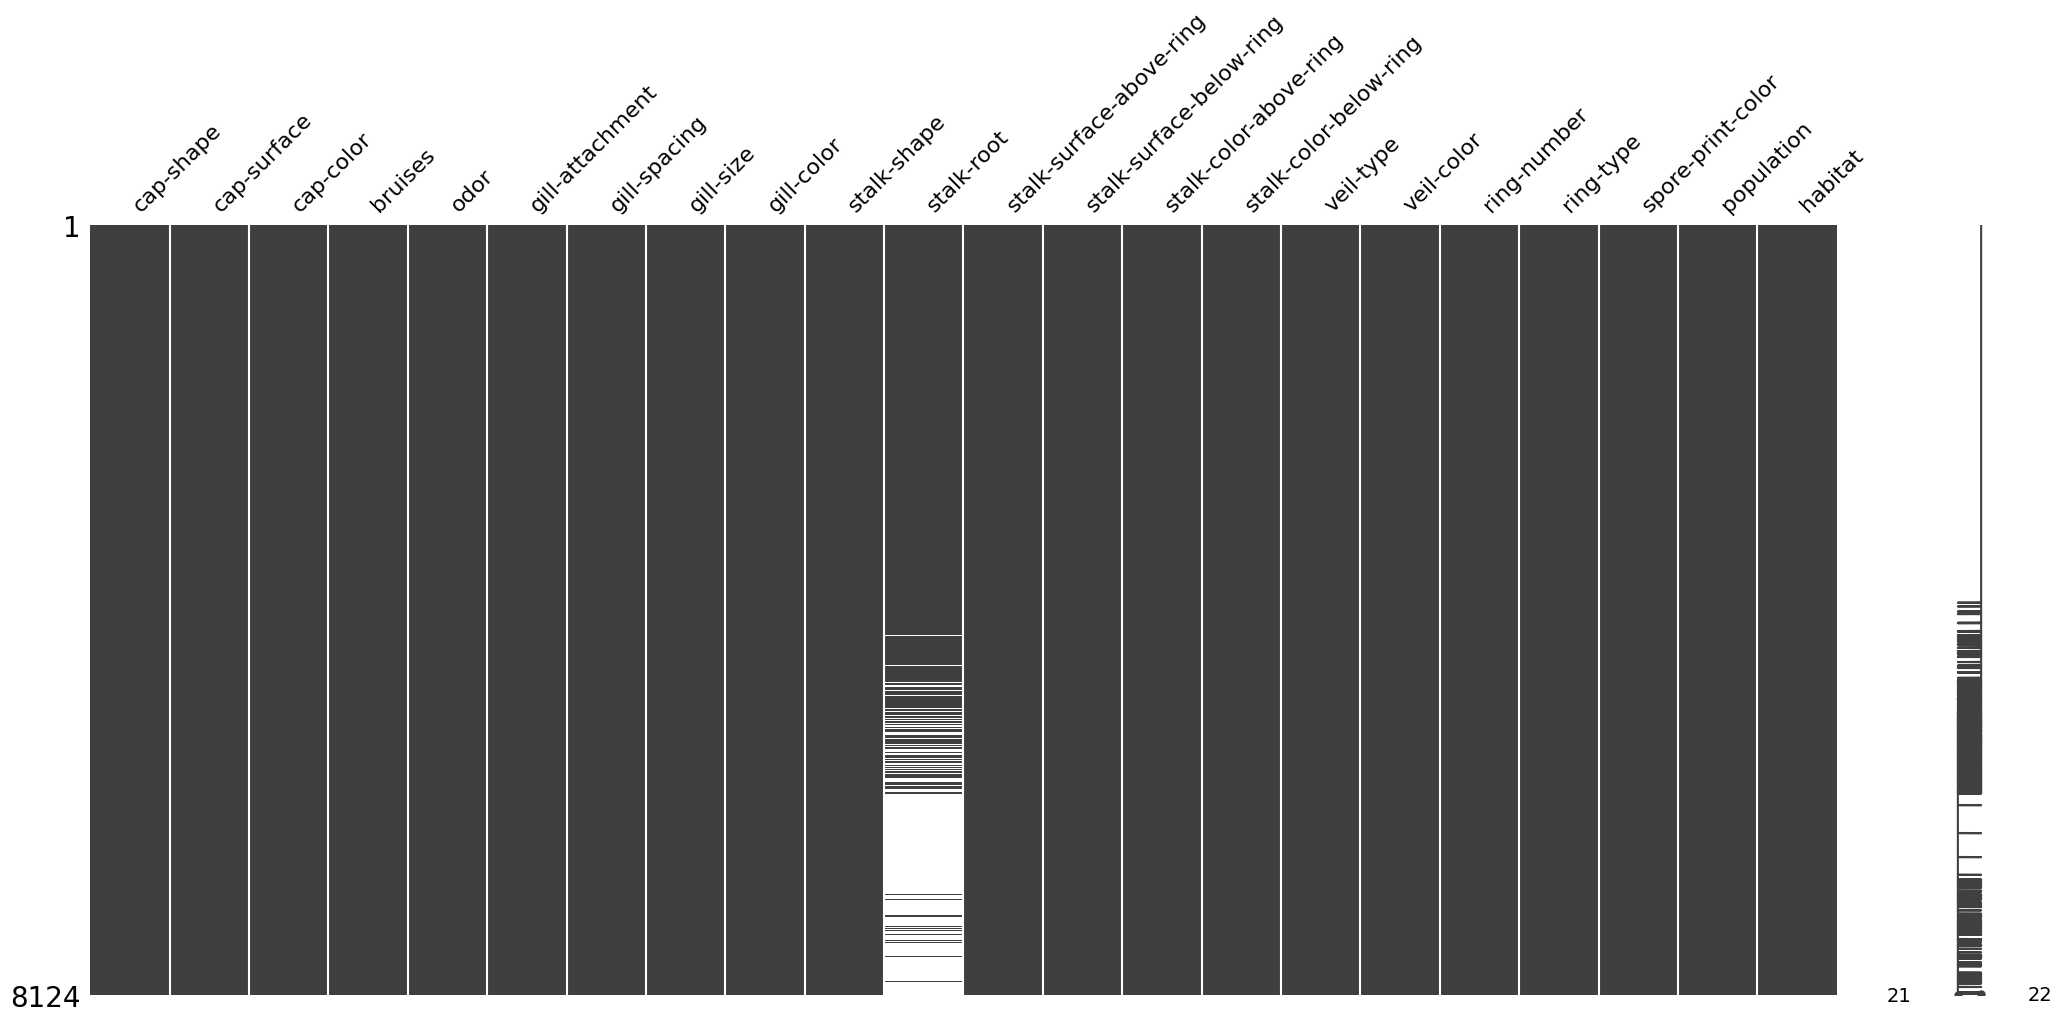

In [47]:
import missingno as msno
import matplotlib.pyplot as plt

data = mushroom.data.features

msno.matrix(data)
plt.show()

In [48]:
missing_percentage = (data['stalk-root'].isnull().sum() / len(data)) * 100
print(f'stalk-root is missing: {missing_percentage:.2f}%')

stalk-root is missing: 30.53%


The 'stalk-root' feature is missing data on 30% of rows. I have very little domain knowledge in this area, so it's not obvious how we should handle this situation.

I'm going to consider these two approaches because the amount of rows missing data is so large:

- Drop the column and check model performance
- Investigate if the stalk root is correlated with other features and use regression imputation to predict the value

Regression imputation will take some work, so I'll use it at the end of the project when validating model performance.

In [49]:
data_drop_stalk = data.drop('stalk-root', axis = 1)

This data set is made up of categorical features, so it will be necessary to use one-hot encoding.

In [50]:
import pandas as pd

data = pd.get_dummies(data, columns=data.columns)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Columns: 116 entries, cap-shape_b to habitat_w
dtypes: bool(116)
memory usage: 920.4 KB


I will also add the target column to the dataset to get ready for binary classification.

In [51]:
data['poisonous'] = mushroom.data.targets['poisonous'].map({'p': True, 'e': False})
data.describe()

,cap-shape_b,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_f,cap-surface_g,cap-surface_s,cap-surface_y,...,population_v,population_y,habitat_d,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u,habitat_w,poisonous
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
top,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
freq,7672,8120,4972,7296,8092,4468,5804,8120,5568,4880,...,4084,6412,4976,5976,7292,7832,6980,7756,7932,4208


And I will check for imbalance in the data between poisonous or edible mushrooms.

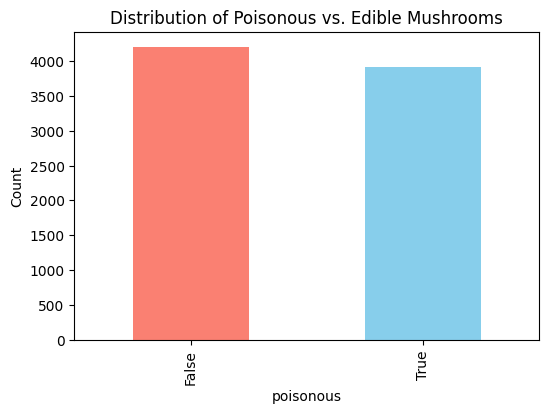

In [52]:
plt.figure(figsize=(6, 4))
plt.title('Distribution of Poisonous vs. Edible Mushrooms')
plt.xlabel('Poisonous (True) / Edible (False)')
plt.ylabel('Count')
plt.xticks(rotation=0)
data['poisonous'].value_counts().plot(kind='bar', color=['salmon', 'skyblue'])
plt.show()

The data seems balanced.

## Exploratory Data Analysis

First, I'll explore the frequance of each feature.

<function matplotlib.pyplot.ylim(*args, **kwargs) -> 'tuple[float, float]'>

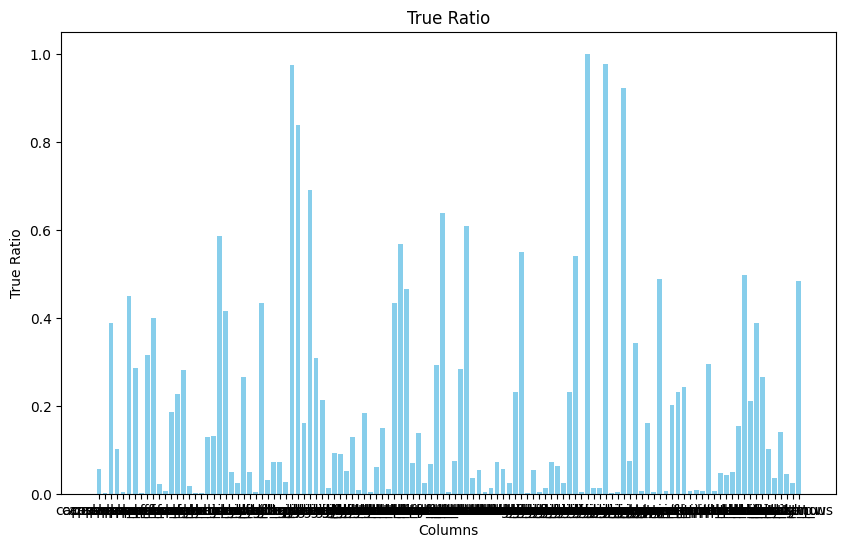

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

true_ratios = {}
for col in data.columns:
    if data[col].dtype == 'bool':
        true_ratios[col] = data[col].mean()

plt.figure(figsize=(10, 6))
plt.bar(true_ratios.keys(), true_ratios.values(), color='skyblue')
plt.xlabel("Columns")
plt.ylabel("True Ratio")
plt.title("True Ratio")
plt.ylim

And explore corelations.

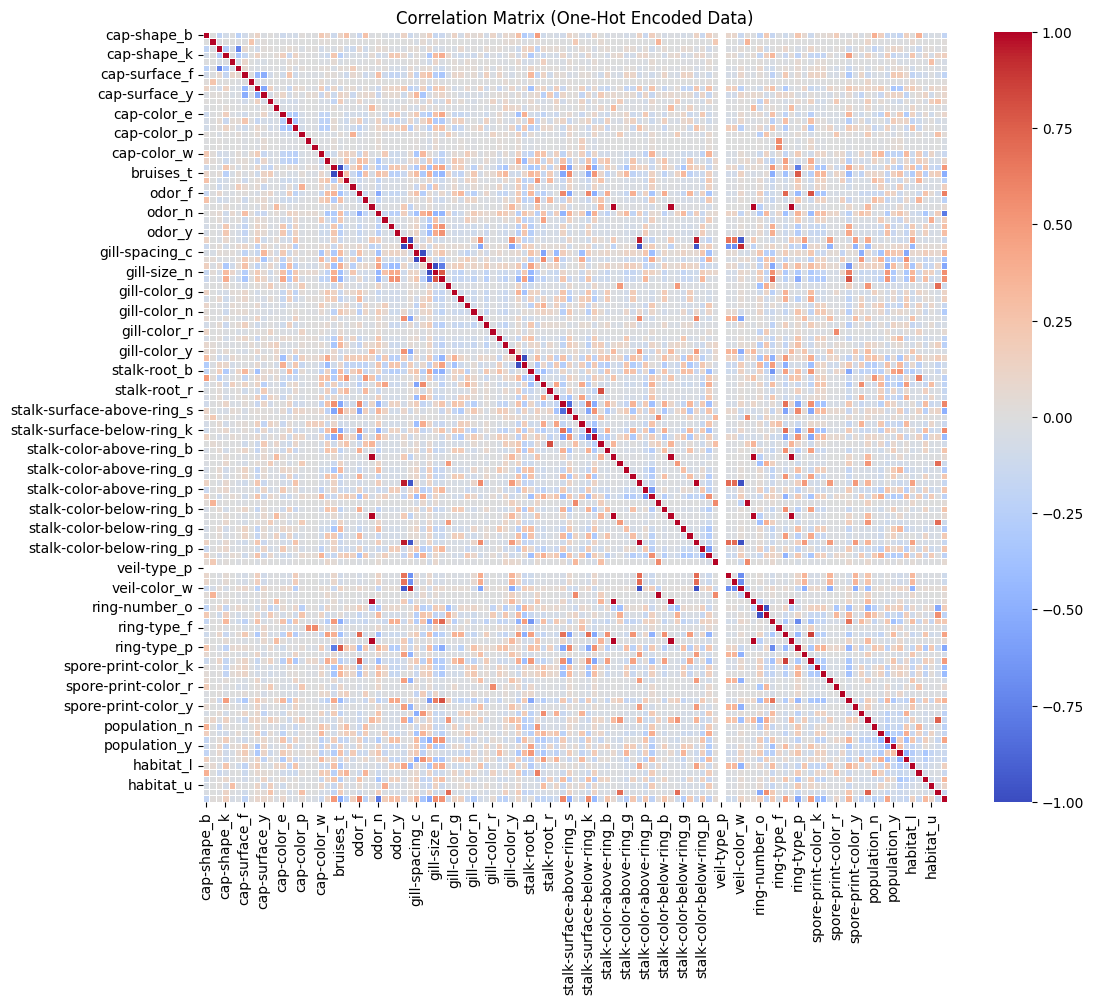

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = data.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap="coolwarm", linewidths=.5, fmt=".2f")
plt.title("Correlation Matrix (One-Hot Encoded Data)")
plt.show()

In [55]:
from scipy.stats import fisher_exact

df = mushroom.data.features
df['poisonous'] = mushroom.data.targets['poisonous'].map({'p': True, 'e': False})

significantly_associated = []

for column in df.columns:
    if column != 'poisonous':
        contingency_table = pd.crosstab(df[column], df['poisonous'])
        _oddsratio, p = fisher_exact(contingency_table)
        if p < 0.005:
            significantly_associated.append(column)

print(significantly_associated)

['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


## Models

### Logistic Regression

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

df = data

X = df.drop('poisonous', axis=1)
y = df['poisonous']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

model = LogisticRegression(
    solver='liblinear', random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

Accuracy: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1257
        True       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



### Decision Trees

In [61]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

Accuracy: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1257
        True       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



In [64]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=100, random_state=42
)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

Accuracy: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1257
        True       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



### Support Vector Machines

In [65]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

model = SVC(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

print(classification_report(y_test, y_pred))

Accuracy: 1.0000
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      1257
        True       1.00      1.00      1.00      1181

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



## Results and Analysis

In [68]:
# todo need to figure out how to make models worse
# todo regression imputation and compare

Columns with missing values: ['stalk-root']


ValueError: could not convert string to float: 'e'

## Conclusion

In [66]:
mushroom

{'data': {'ids': None,
  'features':      cap-shape cap-surface cap-color bruises odor gill-attachment  \
  0            x           s         n       t    p               f   
  1            x           s         y       t    a               f   
  2            b           s         w       t    l               f   
  3            x           y         w       t    p               f   
  4            x           s         g       f    n               f   
  ...        ...         ...       ...     ...  ...             ...   
  8119         k           s         n       f    n               a   
  8120         x           s         n       f    n               a   
  8121         f           s         n       f    n               a   
  8122         k           y         n       f    y               f   
  8123         x           s         n       f    n               a   
  
       gill-spacing gill-size gill-color stalk-shape  ...  \
  0               c         n          k         